In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import timm
import os
from torchvision import datasets, transforms
import time
import os
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from random import shuffle
from PIL import Image
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display

import glob
from itertools import chain
import os
import random
import zipfile
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from transformers import ViTForImageClassification, AdamW
import copy


%matplotlib inline

In [2]:
cv2.__version__

'4.7.0'

In [3]:
timm.__version__

'0.6.13'

In [4]:
np.__version__

'1.24.3'

In [5]:
torch.__version__

'2.0.0'

In [6]:
sklearn.__version__

'1.2.2'

In [7]:
matplotlib.__version__

'3.7.1'

In [8]:
torchvision.__version__

'0.15.0'

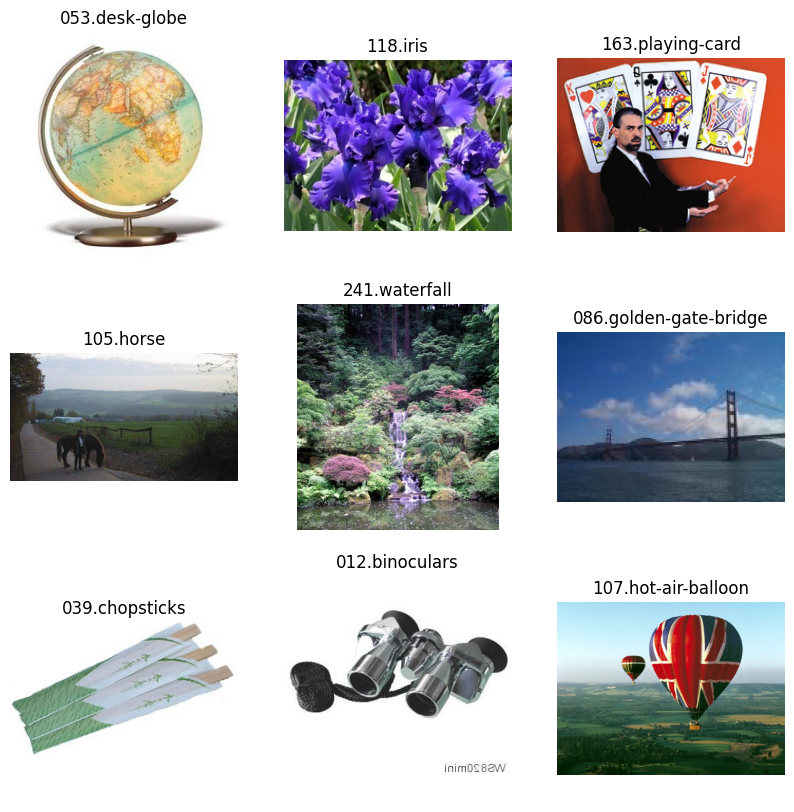

In [22]:
import matplotlib.pyplot as plt
import random

root_folder = r"C:\Users\Oleg\Desktop\Caltech256\test"
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        folder_name = random.choice(os.listdir(root_folder))
        file_name = random.choice(os.listdir(os.path.join(root_folder, folder_name)))
        image = plt.imread(os.path.join(root_folder, folder_name, file_name))
        axs[i, j].imshow(image)
        axs[i, j].axis("off")
        axs[i, j].set_title(folder_name)

plt.show()

In [9]:
model_paths = {
    'mobilevit_s': r'C:\Users\Oleg\Desktop\CW\models\mobilevits-caltech256-e10-lr001-t69.pt',
    'efficientformer': r'C:\Users\Oleg\Desktop\CW\models\eficcientformer-caltech256-e10-lr0003-t78.pt',
    'deit_tiny': r'C:\Users\Oleg\Desktop\CW\models\deit_tiny_distilled_patch16_224-caltech256-e10-lr0001-t79.pt',
    'vit_small': r'C:\Users\Oleg\Desktop\CW\models\vit_small_patch16_224-caltech256-e10-lr0002-t80.pt',
    'swin_s3_tiny': r'C:\Users\Oleg\Desktop\CW\models\swin_s3_tiny_224-caltech256-e10-lr0002-t81.pt',
    'swin_tiny_window7': r'C:\Users\Oleg\Desktop\CW\models\swin_tiny_patch4_window7_224-caltech256-e10-lr0001-t83.pt'
}

In [10]:
device = 'cuda'

In [11]:
models = {}
for model_name, model_path in model_paths.items():
    models[model_name] = torch.load(model_path).to(device)

In [12]:
def size_kb(path_to_file):
    file_size = os.path.getsize(path_to_file)
    kb_size = file_size / 1024
    return(kb_size)

In [13]:
for model_name, model_path in model_paths.items():
    print(model_name, " - ", size_kb(model_path))

mobilevit_s  -  20161.7021484375
efficientformer  -  48369.1298828125
deit_tiny  -  22070.9892578125
vit_small  -  85117.6572265625
swin_s3_tiny  -  111201.220703125
swin_tiny_window7  -  109471.4423828125


In [14]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [15]:
test_dir = r"C:\Users\Oleg\Desktop\Caltech256\test"
kwargs = {'num_workers': 4, 'pin_memory': True} if torch.cuda.is_available() else {}
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, **kwargs) 

In [16]:
criterion = nn.CrossEntropyLoss()

def test(model, loader, dataset):
    epoch_val_accuracy = 0
    epoch_val_loss = 0
    model.eval()
    start = time.time()
    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().sum()
            epoch_val_accuracy += acc
            epoch_val_loss += val_loss
        end = time.time()
    epoch_val_accuracy /= len(dataset)
    epoch_val_loss /= len(dataset)
    return epoch_val_accuracy, epoch_val_loss, (end - start)/len(test_dataset)

In [17]:
for model_name, model in models.items():
    test_accuracy, test_loss, inf_time=test(model.to(device), test_loader, test_dataset)
    print(f"pruned model name : {model_name} - test_loss : {test_loss:.4f} - test_acc: {test_accuracy:.4f} - inference time GPU: {inf_time}\n")

pruned model name : mobilevit_s - test_loss : 0.0850 - test_acc: 0.6940 - inference time GPU: 0.007392409124544689

pruned model name : efficientformer - test_loss : 0.0567 - test_acc: 0.7819 - inference time GPU: 0.004497124870516816

pruned model name : deit_tiny - test_loss : 0.0498 - test_acc: 0.7996 - inference time GPU: 0.0038908676301338233

pruned model name : vit_small - test_loss : 0.0496 - test_acc: 0.8095 - inference time GPU: 0.008986018522053349

pruned model name : swin_s3_tiny - test_loss : 0.0481 - test_acc: 0.8107 - inference time GPU: 0.010483065734104234

pruned model name : swin_tiny_window7 - test_loss : 0.0396 - test_acc: 0.8369 - inference time GPU: 0.009974347427487373

